## Data Preprocessing

In [58]:
import pandas as pd
import glob
import re
from sklearn.cluster import KMeans
import matplotlib as plt

### Por Location


In [59]:


# --------------------------------------------------------------
# 1) Helper: convert DMS (degrees/minutes/seconds + N/S/E/W) → decimal degrees
# --------------------------------------------------------------
def dms_to_decimal(degrees, minutes, seconds, direction):
    """
    Convert DMS (degrees, minutes, seconds) + direction ('N','S','E','W') to decimal degrees.
    """
    dec = float(degrees) + float(minutes)/60 + float(seconds)/3600
    if direction in ['S', 'W']:
        dec = -dec
    return dec



# --------------------------------------------------------------
# 2) Function to parse one station CSV:
#    - Read header lines to extract station name and DMS coordinates.
#    - Read the day×month table, melt into (Date, Temp), attach metadata.
# --------------------------------------------------------------
def parse_station_csv(file_path):
    # Read the first 6 lines (metadata + header row)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        header_lines = [f.readline().strip() for _ in range(6)]
    
    # --- 2.1) Extract Station Name from line 2.  e.g. "測站：南投  Nantou C0I460"
    station_line = header_lines[1]
    station_match = re.search(r"測站：([^ ]+)", station_line)
    station_name = station_match.group(1) if station_match else file_path.split('/')[-1]
    
    # --- 2.2) Extract DMS Latitude/Longitude from line 5.  
    #       e.g. "緯度：23°54'47.55〞N經度：120°40'45.06〞E"
    lat_lon_line = header_lines[4]
    dms_pattern = re.compile(
        r"緯度：(\d+)°(\d+)'([\d.]+)〞([NS])經度：(\d+)°(\d+)'([\d.]+)〞([EW])"
    )
    match = dms_pattern.search(lat_lon_line)
    if match:
        lat_deg, lat_min, lat_sec, lat_dir, lon_deg, lon_min, lon_sec, lon_dir = match.groups()
        lat = dms_to_decimal(lat_deg, lat_min, lat_sec, lat_dir)
        lon = dms_to_decimal(lon_deg, lon_min, lon_sec, lon_dir)
    else:
        lat, lon = None, None

    # --- 2.3) Read the actual table. 
    # The header row is on line 6 (0‐based index row 5), so we skip the first 5 lines.
    # That header looks like: "Day/Month,1,2,…,12,Day/Month"
    df = pd.read_csv(file_path, skiprows=5)
    
    # Drop the last "Day/Month" column if pandas has named it "Day/Month.1"
    if 'Day/Month.1' in df.columns:
        df = df.drop(columns=['Day/Month.1'])
    
    # Rename the first column from "Day/Month" → "Day"
    df = df.rename(columns={'Day/Month': 'Day'})
    
    # Melt from wide (day×month) → long (Day, Month, Temp)
    df_long = df.melt(id_vars='Day', var_name='Month', value_name='Temp')
    
    # Convert Day & Month to numeric; drop any rows where Temp is missing or invalid
    df_long['Day']   = pd.to_numeric(df_long['Day'], errors='coerce')
    df_long['Month'] = pd.to_numeric(df_long['Month'], errors='coerce')
    df_long = df_long.dropna(subset=['Day', 'Month', 'Temp'])
    
    # Build a proper datetime (year=2024) from Day/Month
    df_long['Date'] = pd.to_datetime(
        dict(year=2024, month=df_long['Month'].astype(int), day=df_long['Day'].astype(int)),
        errors='coerce'
    )
    df_long = df_long.dropna(subset=['Date'])
    
    # Attach station metadata
    df_long['Station']   = station_name
    df_long['Latitude']  = lat
    df_long['Longitude'] = lon
    
    # Keep only the columns we care about
    return df_long[['Station', 'Latitude', 'Longitude', 'Date', 'Temp']]



# --------------------------------------------------------------
# 3) Loop over all CSV files in /mnt/data (adjust pattern if needed)
# --------------------------------------------------------------
file_paths = glob.glob('C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data/*.csv')
all_stations = []

for fp in file_paths:
    print(fp)
    try:
        station_df = parse_station_csv(fp)
        all_stations.append(station_df)
    except Exception as e:
        print(f"Error parsing {fp}: {e}")

# If nothing parsed, exit early
if not all_stations:
    raise RuntimeError("No station data was successfully parsed. Check file formats.")





C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 五股 _ csv_1.csv
C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 南投 _ csv_7.csv
C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 員林 _ csv_16.csv
C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 嘉義 _ csv_9.csv
C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 基隆 _ csv_3.csv
C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 宜蘭 _ csv_12.csv
C:/Users/Tino/Documents/PowerComsuption_MachineLearning/PowerConsumtionPrediction/Raw Data/Meteorological Data\逐日平均氣溫年報表_2024 恆春 _ csv_8.csv
C:/Users/Ti

In [60]:
# --------------------------------------------------------------
# 4) Concatenate all stations → one big DataFrame of daily temps
# --------------------------------------------------------------
df_all = pd.concat(all_stations, ignore_index=True)

# Sanity check: 
print(df_all[['Station','Latitude','Longitude','Date','Temp']].head())


  Station   Latitude   Longitude       Date  Temp
0      五股  25.076228  121.419053 2024-01-01  16.3
1      五股  25.076228  121.419053 2024-01-02  20.1
2      五股  25.076228  121.419053 2024-01-03  14.6
3      五股  25.076228  121.419053 2024-01-04  15.1
4      五股  25.076228  121.419053 2024-01-05  17.5


C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\356243181.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(all_stations, ignore_index=True)


In [61]:
print(df_all['Temp'].dtype)         # likely “object”
print(df_all['Temp'].head(10))      # see a few raw values
# Try to convert every Temp into a float; invalid parses become NaN
df_all['Temp'] = pd.to_numeric(df_all['Temp'], errors='coerce')

# If you want to drop rows where Temp could not be converted:
df_all = df_all.dropna(subset=['Temp'])
# (Now df_all['Temp'] is guaranteed float64.)

print(df_all['Temp'].dtype)         # should now be float64
print(df_all['Temp'].isna().sum(), "rows dropped because Temp was non‐numeric")




object
0    16.3
1    20.1
2    14.6
3    15.1
4    17.5
5    17.7
6    17.0
7    18.9
8    18.1
9    15.1
Name: Temp, dtype: object
float64
0 rows dropped because Temp was non‐numeric


In [62]:
# --------------------------------------------------------------
# 5) Compute each station’s monthly mean temperature
# --------------------------------------------------------------
df_all['Month'] = df_all['Date'].dt.month
monthly_means = (
    df_all
    .groupby(['Station', 'Latitude', 'Longitude', 'Month'])['Temp']
    .mean()
    .reset_index()
)

# Pivot so that each station is one row, with 12 columns (Month=1…12)
df_features = (
    monthly_means
    .pivot_table(
        index=['Station', 'Latitude', 'Longitude'],
        columns='Month',
        values='Temp'
    )
    .reset_index()
)

# Rename columns from 1→'Month_1', 2→'Month_2', … up to 12
new_cols = ['Station', 'Latitude', 'Longitude'] + [f'Month_{m}' for m in range(1, 13)]
df_features.columns = new_cols

# If any monthly values are still NaN (e.g. Feb 29 missing), fill via forward/backfill
df_features = df_features.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)



C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\236521340.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features = df_features.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\236521340.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features = df_features.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\236521340.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features = df_features.fillna(method='ffill', axis=1).fillna(method='bfill', axis

In [63]:
# Plot each station’s 12-month temperature profile
months = list(range(1, 13))
plt.figure(figsize=(10, 6))
for idx, row in df_features.iterrows():
    temps = [row[f'Month_{m}'] for m in months]
    plt.plot(months, temps, label=row['Station'])

plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Mean Temperature (°C)')
plt.title('Monthly Mean Temperature Profiles by Station (2024)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()


TypeError: 'module' object is not callable

=== Station → 12 Month Means ===
Station  Latitude  Longitude   Month_1   Month_2   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8   Month_9  Month_10  Month_11  Month_12  ClimateCluster
     五股 25.076228 121.419053 16.258065 17.586207 18.929032 24.463333 25.029032 28.053333 29.725806 29.374194 28.626667 24.280645 20.350000 15.661290               2
     南投 23.913208 120.679183 17.441935 19.562069 21.361290 26.330000 26.625806 28.730000 29.093548 29.145161 28.563333 26.977419 23.420000 18.190323               0
     斗南 23.680478 120.470231 17.067742 18.910345 20.861290 25.856667 26.032258 28.876667 29.167742 29.025806 28.516667 26.316129 22.690000 17.851613               0
  新竹市東區 24.800439 120.978736 15.925806 16.896552 18.893548 24.313333 24.941935 28.440000 29.522581 28.987097 28.496667 25.138710 21.403333 16.561290               3
     深坑 25.004489 121.620106 16.196552 17.936000 18.964516 24.760000 25.096774 28.264286 29.593333 29.207407 28.873333 26.116129 19.121429 17.

C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\2113353477.py:34: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\2113353477.py:34: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\2113353477.py:34: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\2113353477.py:34: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\2113353477.py:34: UserWarning: Glyph 26007 (\N{CJK UNIFIED IDEOGRAPH-6597}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Tino\AppData\Local\Temp\ipykernel_16460\2113353477.py:34: UserWarning: Glyph 26032 (\N{CJK 

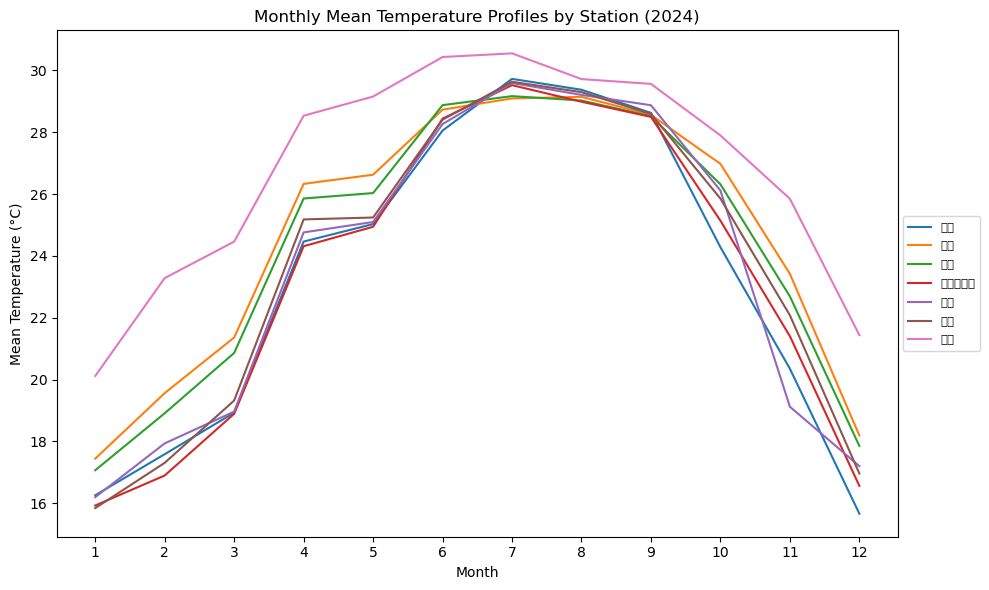

In [ ]:
# --------------------------------------------------------------
# 6) (Optional) Run K-Means clustering on the 12 monthly columns
# --------------------------------------------------------------
from sklearn.cluster import KMeans
monthly_cols = [f'Month_{m}' for m in range(1, 13)]
kmeans = KMeans(n_clusters=4, random_state=42)
df_features['ClimateCluster'] = kmeans.fit_predict(df_features[monthly_cols])

# --------------------------------------------------------------
# 7) Print or save the final DataFrame
# --------------------------------------------------------------
print("=== Station → 12 Month Means ===")
print(df_features.to_string(index=False))

# Or save to CSV:
df_features.to_csv('station_climate_features_2024.csv', index=False)
print("Saved station_climate_features_2024.csv")

# --------------------------------------------------------------
# 8) Visualize each station’s 12‐month profile
# --------------------------------------------------------------
months = list(range(1, 13))
plt.figure(figsize=(10, 6))

for idx, row in df_features.iterrows():
    temps = [row[f'Month_{m}'] for m in months]
    plt.plot(months, temps, label=row['Station'])

plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Mean Temperature (°C)')
plt.title('Monthly Mean Temperature Profiles by Station (2024)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

In [64]:
# 1) After you have built df_features, simply:
print(df_features)

  Station   Latitude   Longitude    Month_1    Month_2    Month_3    Month_4  \
0      五股  25.076228  121.419053  16.258065  17.586207  18.929032  24.463333   
1      南投  23.913208  120.679183  17.441935  19.562069  21.361290  26.330000   
2      斗南  23.680478  120.470231  17.067742  18.910345  20.861290  25.856667   
3   新竹市東區  24.800439  120.978736  15.925806  16.896552  18.893548  24.313333   
4      深坑  25.004489  121.620106  16.196552  17.936000  18.964516  24.760000   
5      苗栗  24.566667  120.816444  15.841935  17.306897  19.322581  25.180000   
6      麟洛  22.652556  120.519139  20.116129  23.282759  24.461290  28.533333   

     Month_5    Month_6    Month_7    Month_8    Month_9   Month_10  \
0  25.029032  28.053333  29.725806  29.374194  28.626667  24.280645   
1  26.625806  28.730000  29.093548  29.145161  28.563333  26.977419   
2  26.032258  28.876667  29.167742  29.025806  28.516667  26.316129   
3  24.941935  28.440000  29.522581  28.987097  28.496667  25.138710   
4  2